# Merge

**Prerequisites**

- {doc}`Reshape <reshape>`

**Outcomes**

- Know the different pandas routines for combining datasets
- Know when to use `pd.concat` vs `pd.merge` vs `pd.join`
- Be able to apply the three main combining routines

**Data**

- WDI data on GDP components, population, and square miles of countries
- Book ratings: 6,000,000 ratings for the 10,000 most rated books on
  [Goodreads](https://www.goodreads.com/)
- Details for all delayed US domestic flights in November 2016,
  obtained from the [Bureau of Transportation
  Statistics](https://www.transtats.bts.gov/OT_Delay/OT_DelayCause1.asp)


```{literalinclude} ../_static/colab_light.raw
```

## Combining Datasets

Often, we will want perform joint analysis on data from different sources.

For example, when analyzing the regional sales for a company, we might
want to include industry aggregates or demographic information for each
region.

Or perhaps we are working with product-level data, have a list of
product groups in a separate dataset, and want to compute aggregate
statistics for each group.

In [1]:
import pandas as pd
import qeds
%matplotlib inline
# activate plot theme
import qeds
qeds.themes.mpl_style();

from IPython.display import display

In [2]:
# from WDI. Units trillions of 2010 USD
url = "https://datascience.quantecon.org/assets/data/wdi_data.csv"
wdi = pd.read_csv(url).set_index(["country", "year"])
wdi.info()

wdi2017 = wdi.xs(2017, level="year")
wdi2017

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 72 entries, ('Canada', 2017) to ('United States', 2000)
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   GovExpend    72 non-null     float64
 1   Consumption  72 non-null     float64
 2   Exports      72 non-null     float64
 3   Imports      72 non-null     float64
 4   GDP          72 non-null     float64
dtypes: float64(5)
memory usage: 3.9+ KB


,GovExpend,Consumption,Exports,Imports,GDP
country,,,,,
Canada,0.372665,1.095475,0.582831,0.600031,1.868164
Germany,0.745579,2.112009,1.930563,1.666348,3.883870
United Kingdom,0.549538,1.809154,0.862629,0.933145,2.818704
United States,2.405743,12.019266,2.287071,3.069954,17.348627


In [3]:
wdi2016_17 = wdi.loc[pd.IndexSlice[:, [2016, 2017]],: ]
wdi2016_17

,,GovExpend,Consumption,Exports,Imports,GDP
country,year,,,,,
Canada,2016,0.364899,1.058426,0.576394,0.575775,1.814016
Germany,2016,0.734014,2.075615,1.844949,1.589495,3.801859
United Kingdom,2016,0.550596,1.772348,0.816792,0.901494,2.768241
United States,2016,2.407981,11.722133,2.219937,2.936004,16.972348
Canada,2017,0.372665,1.095475,0.582831,0.600031,1.868164
Germany,2017,0.745579,2.112009,1.930563,1.666348,3.883870
United Kingdom,2017,0.549538,1.809154,0.862629,0.933145,2.818704
United States,2017,2.405743,12.019266,2.287071,3.069954,17.348627


In [4]:
# Data from https://www.nationmaster.com/country-info/stats/Geography/Land-area/Square-miles
# units -- millions of square miles
sq_miles = pd.Series({
   "United States": 3.8,
   "Canada": 3.8,
   "Germany": 0.137,
   "United Kingdom": 0.0936,
   "Russia": 6.6,
}, name="sq_miles").to_frame()
sq_miles.index.name = "country"
sq_miles

,sq_miles
country,
United States,3.8000
Canada,3.8000
Germany,0.1370
United Kingdom,0.0936
Russia,6.6000


In [5]:
# from WDI. Units millions of people
pop_url = "https://datascience.quantecon.org/assets/data/wdi_population.csv"
pop = pd.read_csv(pop_url).set_index(["country", "year"])
pop.info()
pop.head(10)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 72 entries, ('Canada', 2017) to ('United States', 2000)
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Population  72 non-null     float64
dtypes: float64(1)
memory usage: 1.7+ KB


Population
country year            
Canada  2017   36.540268
        2016   36.109487
        2015   35.702908
        2014   35.437435
        2013   35.082954
        2012   34.714222
        2011   34.339328
        2010   34.004889
        2009   33.628895
        2008   33.247118

Suppose that we were asked to compute a number of statistics with the data above:

- As a measure of land usage or productivity, what is Consumption per square mile?
- What is GDP per capita (per person) for each country in each year? How about
  Consumption per person?
- What is the population density of each country? How much does it change over time?

Notice that to answer any of the questions from above, we will have to use data
from more than one of our DataFrames.

In this lecture, we will learn many techniques for combining datasets that
originate from different sources, careful to ensure that data is properly
aligned.

In pandas three main methods can combine datasets:

1. `pd.concat([dfs...])`
1. `pd.merge(df1, df2)`
1. `df1.join(df2)`

We'll look at each one.

## `pd.concat`

The `pd.concat` function is used to stack two or more DataFrames
together.

An example of when you might want to do this is if you have monthly data
in separate files on your computer and would like to have 1 year of data
in a single DataFrame.

The first argument to `pd.concat` is a list of DataFrames to be
stitched together.

The other commonly used argument is named `axis`.

As we have seen before, many pandas functions have an `axis` argument
that specifies whether a particular operation should happen down rows
(`axis=0`) or along columns (`axis=1`).

In the context of `pd.concat`, setting `axis=0` (the default case)
will stack DataFrames on top of one another while `axis=1` stacks them
side by side.

We'll look at each case separately.

### `axis=0`

When we call `pd.concat` and set `axis=0`, the list of DataFrames
passed in the first argument will be stacked on top of one another.

Let's try it out here.

In [6]:
# equivalent to pd.concat([wdi2017, sq_miles]) -- axis=0 is default
pd.concat([wdi2017, sq_miles], axis=0)

,GovExpend,Consumption,Exports,Imports,GDP,sq_miles
country,,,,,,
Canada,0.372665,1.095475,0.582831,0.600031,1.868164,NaN
Germany,0.745579,2.112009,1.930563,1.666348,3.883870,NaN
United Kingdom,0.549538,1.809154,0.862629,0.933145,2.818704,NaN
United States,2.405743,12.019266,2.287071,3.069954,17.348627,NaN
United States,NaN,NaN,NaN,NaN,NaN,3.8000
Canada,NaN,NaN,NaN,NaN,NaN,3.8000
Germany,NaN,NaN,NaN,NaN,NaN,0.1370
United Kingdom,NaN,NaN,NaN,NaN,NaN,0.0936
Russia,NaN,NaN,NaN,NaN,NaN,6.6000


Notice a few things:

The number of rows in the output is the total number
: of rows in all inputs. The labels are all from the original
  DataFrames.

- The column labels are all the distinct column labels from all the inputs.
- For columns that appeared only in one input, the value for all row labels
  originating from a different input is equal to `NaN` (marked as missing).

### `axis=1`

In this example, concatenating by stacking
side-by-side makes more sense.

We accomplish this by passing `axis=1` to `pd.concat`:

In [7]:
pd.concat([wdi2017, sq_miles], axis=1)

,GovExpend,Consumption,Exports,Imports,GDP,sq_miles
country,,,,,,
Canada,0.372665,1.095475,0.582831,0.600031,1.868164,3.8000
Germany,0.745579,2.112009,1.930563,1.666348,3.883870,0.1370
United Kingdom,0.549538,1.809154,0.862629,0.933145,2.818704,0.0936
United States,2.405743,12.019266,2.287071,3.069954,17.348627,3.8000
Russia,NaN,NaN,NaN,NaN,NaN,6.6000


Notice here that

- The index entries are all unique index entries that appeared in any DataFrame.
- The column labels are all column labels from the inputs.
- As `wdi2017` didn't have a `Russia` row, the value for all of its columns
  is `NaN`.

Now we can answer one of our questions from above: What is
Consumption per square mile?

In [8]:
temp = pd.concat([wdi2017, sq_miles], axis=1)
temp["Consumption"] / temp["sq_miles"]

country
Canada             0.288283
Germany           15.416124
United Kingdom    19.328569
United States      3.162965
Russia                  NaN
dtype: float64

## `pd.merge`

`pd.merge` operates on two DataFrames at a time and is primarily used
to bring columns from one DataFrame into another, *aligning* data based
on one or more "key" columns.

This is a somewhat difficult concept to grasp by reading, so let's look at some
examples.

In [9]:
pd.merge(wdi2017, sq_miles, on="country")

,GovExpend,Consumption,Exports,Imports,GDP,sq_miles
country,,,,,,
Canada,0.372665,1.095475,0.582831,0.600031,1.868164,3.8000
Germany,0.745579,2.112009,1.930563,1.666348,3.883870,0.1370
United Kingdom,0.549538,1.809154,0.862629,0.933145,2.818704,0.0936
United States,2.405743,12.019266,2.287071,3.069954,17.348627,3.8000


The output here looks very similar to what we saw with `concat` and
`axis=1`, except that the row for `Russia` does not appear.

We will talk more about why this happened soon.

For now, let's look at a slightly more intriguing example:

In [10]:
pd.merge(wdi2016_17, sq_miles, on="country")

,GovExpend,Consumption,Exports,Imports,GDP,sq_miles
country,,,,,,
Canada,0.364899,1.058426,0.576394,0.575775,1.814016,3.8000
Canada,0.372665,1.095475,0.582831,0.600031,1.868164,3.8000
Germany,0.734014,2.075615,1.844949,1.589495,3.801859,0.1370
Germany,0.745579,2.112009,1.930563,1.666348,3.883870,0.1370
United Kingdom,0.550596,1.772348,0.816792,0.901494,2.768241,0.0936
United Kingdom,0.549538,1.809154,0.862629,0.933145,2.818704,0.0936
United States,2.407981,11.722133,2.219937,2.936004,16.972348,3.8000
United States,2.405743,12.019266,2.287071,3.069954,17.348627,3.8000


Here's how we think about what happened:

- The data in `wdi2016_17` is copied over exactly as is.
- Because `country` was on the index for both DataFrames, it is on the
  index of the output.
- We lost the year on the index -- we'll work on getting it back below.
- The additional column in `sq_miles` was added to column labels for the
  output.
- The data from the `sq_miles` column was added to the output by looking up
  rows where the `country` in the two DataFrames lined up.
  -  Note that all the countries appeared twice, and the data in `sq_miles` was repeated. This is because `wdi2016_17` had two rows for each country.
  -  Also note that because `Russia` did not appear in `wdi2016_17`, the value `sq_miles.loc["Russia"]` (i.e. `6.6`) is not used the output.

How do we get the year back?

We must first call `reset_index` on `wdi2016_17` so
that in the first step when all columns are copied over, `year` is included.

In [11]:
pd.merge(wdi2016_17.reset_index(), sq_miles, on="country")

,country,year,GovExpend,Consumption,Exports,Imports,GDP,sq_miles
0,Canada,2016,0.364899,1.058426,0.576394,0.575775,1.814016,3.8000
1,Canada,2017,0.372665,1.095475,0.582831,0.600031,1.868164,3.8000
2,Germany,2016,0.734014,2.075615,1.844949,1.589495,3.801859,0.1370
3,Germany,2017,0.745579,2.112009,1.930563,1.666348,3.883870,0.1370
4,United Kingdom,2016,0.550596,1.772348,0.816792,0.901494,2.768241,0.0936
5,United Kingdom,2017,0.549538,1.809154,0.862629,0.933145,2.818704,0.0936
6,United States,2016,2.407981,11.722133,2.219937,2.936004,16.972348,3.8000
7,United States,2017,2.405743,12.019266,2.287071,3.069954,17.348627,3.8000


### Multiple Columns

Sometimes, we need to merge multiple columns.

For example our `pop` and `wdi2016_17` DataFrames both have observations
organized by country and year.

To properly merge these datasets, we would need to align the data by
both country and year.

We pass a list to the `on` argument to accomplish this:

In [12]:
pd.merge(wdi2016_17, pop, on=["country", "year"])

,,GovExpend,Consumption,Exports,Imports,GDP,Population
country,year,,,,,,
Canada,2016,0.364899,1.058426,0.576394,0.575775,1.814016,36.109487
Germany,2016,0.734014,2.075615,1.844949,1.589495,3.801859,82.348669
United Kingdom,2016,0.550596,1.772348,0.816792,0.901494,2.768241,65.595565
United States,2016,2.407981,11.722133,2.219937,2.936004,16.972348,323.071342
Canada,2017,0.372665,1.095475,0.582831,0.600031,1.868164,36.540268
Germany,2017,0.745579,2.112009,1.930563,1.666348,3.883870,82.657002
United Kingdom,2017,0.549538,1.809154,0.862629,0.933145,2.818704,66.058859
United States,2017,2.405743,12.019266,2.287071,3.069954,17.348627,325.147121


Now, we can answer more of our questions from above: What is GDP per capita (per
person) for each country in each year? How about Consumption per person?

In [13]:
wdi_pop = pd.merge(wdi2016_17, pop, on=["country", "year"])
wdi_pop["GDP"] / wdi_pop["Population"]

country         year
Canada          2016    0.050237
Germany         2016    0.046168
United Kingdom  2016    0.042202
United States   2016    0.052534
Canada          2017    0.051126
Germany         2017    0.046988
United Kingdom  2017    0.042670
United States   2017    0.053356
dtype: float64

In [14]:
wdi_pop["Consumption"] / wdi_pop["Population"]

country         year
Canada          2016    0.029312
Germany         2016    0.025205
United Kingdom  2016    0.027019
United States   2016    0.036283
Canada          2017    0.029980
Germany         2017    0.025551
United Kingdom  2017    0.027387
United States   2017    0.036966
dtype: float64

````{admonition} Exercise
:name: pd-mrg-dir1
See exercise 1 in the {ref}`exercise list <pd-mrg-ex>`.
````

## Arguments to `merge`

The `pd.merge` function can take many optional arguments.

We'll talk about a few of the most commonly-used ones here and refer you
to the
[documentation](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.merge.html#pandas.merge)
for more details.

We'll follow the pandas convention and refer to the first argument to
`pd.merge` as `left` and call the second `right`.

### `on`

We have already seen this one used before, but we want to point out that on
is optional.

If nothing is given for this argument, pandas will use **all** columns
in `left` and `right` with the same name.

In our example, `country` is the only column that appears in both
DataFrames, so it is used for `on` if we don't pass anything.

The following two are equivalent.

In [15]:
pd.merge(wdi2017, sq_miles, on="country")

,GovExpend,Consumption,Exports,Imports,GDP,sq_miles
country,,,,,,
Canada,0.372665,1.095475,0.582831,0.600031,1.868164,3.8000
Germany,0.745579,2.112009,1.930563,1.666348,3.883870,0.1370
United Kingdom,0.549538,1.809154,0.862629,0.933145,2.818704,0.0936
United States,2.405743,12.019266,2.287071,3.069954,17.348627,3.8000


In [16]:
# if we move index back to columns, the `on` is un-necessary
pd.merge(wdi2017.reset_index(), sq_miles.reset_index())

,country,GovExpend,Consumption,Exports,Imports,GDP,sq_miles
0,Canada,0.372665,1.095475,0.582831,0.600031,1.868164,3.8000
1,Germany,0.745579,2.112009,1.930563,1.666348,3.883870,0.1370
2,United Kingdom,0.549538,1.809154,0.862629,0.933145,2.818704,0.0936
3,United States,2.405743,12.019266,2.287071,3.069954,17.348627,3.8000


### `left_on`, `right_on`

Above, we used the `on` argument to identify a column in both `left`
and `right` that was used to align data.

Sometimes, both DataFrames don't have the same name for this column.

In that case, we use the `left_on` and `right_on` arguments, passing
the proper column name(s) to align the data.

We'll show you an example below, but it is somewhat silly as our
DataFrames do both have the `country` column.

In [17]:
pd.merge(wdi2017, sq_miles, left_on="country", right_on="country")

,GovExpend,Consumption,Exports,Imports,GDP,sq_miles
country,,,,,,
Canada,0.372665,1.095475,0.582831,0.600031,1.868164,3.8000
Germany,0.745579,2.112009,1.930563,1.666348,3.883870,0.1370
United Kingdom,0.549538,1.809154,0.862629,0.933145,2.818704,0.0936
United States,2.405743,12.019266,2.287071,3.069954,17.348627,3.8000


### `left_index`, `right_index`

Sometimes, as in our example, the key used to align data is actually in the
index instead of one of the columns.

In this case, we can use the `left_index` or `right_index` arguments.

We should only set these values to a boolean (`True` or `False`).

Let's practice with this.

In [18]:
pd.merge(wdi2017, sq_miles, left_on="country", right_index=True)

,GovExpend,Consumption,Exports,Imports,GDP,sq_miles
country,,,,,,
Canada,0.372665,1.095475,0.582831,0.600031,1.868164,3.8000
Germany,0.745579,2.112009,1.930563,1.666348,3.883870,0.1370
United Kingdom,0.549538,1.809154,0.862629,0.933145,2.818704,0.0936
United States,2.405743,12.019266,2.287071,3.069954,17.348627,3.8000


### `how`

The `how` is perhaps the most powerful, but most conceptually
difficult of the arguments we will cover.

This argument controls which values from the key column(s) appear in the
output.

The 4 possible options for this argument are summarized in
the image below.

```{figure} ../_static/merge_venns.png
:alt: merge\_venns.png
```

In words, we have:

- `left`: Default and what we described above. It uses
  the keys from the `left` DataFrame.
- `right`: Output will contain all keys from `right`.
- `inner`: The output will only contain keys that appear in *both*
  `left` and `right`.
- `outer`: The output will contain any key found in either `left`
  or `right`.

In addition to the above, we will use the following two DataFrames to
illustrate the `how` option.

In [19]:
wdi2017_no_US = wdi2017.drop("United States")
wdi2017_no_US

,GovExpend,Consumption,Exports,Imports,GDP
country,,,,,
Canada,0.372665,1.095475,0.582831,0.600031,1.868164
Germany,0.745579,2.112009,1.930563,1.666348,3.883870
United Kingdom,0.549538,1.809154,0.862629,0.933145,2.818704


In [20]:
sq_miles_no_germany = sq_miles.drop("Germany")
sq_miles_no_germany

,sq_miles
country,
United States,3.8000
Canada,3.8000
United Kingdom,0.0936
Russia,6.6000


Now, let's see all the possible `how` options.

In [21]:
# default
pd.merge(wdi2017, sq_miles, on="country", how="left")

,GovExpend,Consumption,Exports,Imports,GDP,sq_miles
country,,,,,,
Canada,0.372665,1.095475,0.582831,0.600031,1.868164,3.8000
Germany,0.745579,2.112009,1.930563,1.666348,3.883870,0.1370
United Kingdom,0.549538,1.809154,0.862629,0.933145,2.818704,0.0936
United States,2.405743,12.019266,2.287071,3.069954,17.348627,3.8000


In [22]:
# notice ``Russia`` is included
pd.merge(wdi2017, sq_miles, on="country", how="right")

,GovExpend,Consumption,Exports,Imports,GDP,sq_miles
country,,,,,,
United States,2.405743,12.019266,2.287071,3.069954,17.348627,3.8000
Canada,0.372665,1.095475,0.582831,0.600031,1.868164,3.8000
Germany,0.745579,2.112009,1.930563,1.666348,3.883870,0.1370
United Kingdom,0.549538,1.809154,0.862629,0.933145,2.818704,0.0936
Russia,NaN,NaN,NaN,NaN,NaN,6.6000


In [23]:
# notice no United States or Russia
pd.merge(wdi2017_no_US, sq_miles, on="country", how="inner")

,GovExpend,Consumption,Exports,Imports,GDP,sq_miles
country,,,,,,
Canada,0.372665,1.095475,0.582831,0.600031,1.868164,3.8000
Germany,0.745579,2.112009,1.930563,1.666348,3.883870,0.1370
United Kingdom,0.549538,1.809154,0.862629,0.933145,2.818704,0.0936


In [24]:
# includes all 5, even though they don't all appear in either DataFrame
pd.merge(wdi2017_no_US, sq_miles_no_germany, on="country", how="outer")

,GovExpend,Consumption,Exports,Imports,GDP,sq_miles
country,,,,,,
Canada,0.372665,1.095475,0.582831,0.600031,1.868164,3.8000
Germany,0.745579,2.112009,1.930563,1.666348,3.883870,NaN
United Kingdom,0.549538,1.809154,0.862629,0.933145,2.818704,0.0936
United States,NaN,NaN,NaN,NaN,NaN,3.8000
Russia,NaN,NaN,NaN,NaN,NaN,6.6000


````{admonition} Exercise
:name: pd-mrg-dir2
See exercise 2 in the {ref}`exercise list <pd-mrg-ex>`.
````
````{admonition} Exercise
:name: pd-mrg-dir3
See exercise 3 in the {ref}`exercise list <pd-mrg-ex>`.
````

### `df.merge(df2)`

Note that the DataFrame type has a `merge` *method*.

It is the same as the function we have been working with, but passes the
DataFrame before the period as `left`.

Thus `df.merge(other)` is equivalent to `pd.merge(df, other)`.

In [25]:
wdi2017.merge(sq_miles, on="country", how="right")

,GovExpend,Consumption,Exports,Imports,GDP,sq_miles
country,,,,,,
United States,2.405743,12.019266,2.287071,3.069954,17.348627,3.8000
Canada,0.372665,1.095475,0.582831,0.600031,1.868164,3.8000
Germany,0.745579,2.112009,1.930563,1.666348,3.883870,0.1370
United Kingdom,0.549538,1.809154,0.862629,0.933145,2.818704,0.0936
Russia,NaN,NaN,NaN,NaN,NaN,6.6000


## `df.join`

The `join` method for a DataFrame is very similar to the `merge`
method described above, but only allows you to use the index of the
`right` DataFrame as the join key.

Thus, `left.join(right, on="country")` is equivalent to calling
`pd.merge(left, right, left_on="country", right_index=True)`.

The implementation of the `join` method calls `merge` internally,
but sets the `left_on` and `right_index` arguments for you.

You can do anything with `df.join` that you can do with
`df.merge`, but df.join` is more convenient to use if the keys of `right`
are in the index.

In [26]:
wdi2017.join(sq_miles, on="country")

,GovExpend,Consumption,Exports,Imports,GDP,sq_miles
country,,,,,,
Canada,0.372665,1.095475,0.582831,0.600031,1.868164,3.8000
Germany,0.745579,2.112009,1.930563,1.666348,3.883870,0.1370
United Kingdom,0.549538,1.809154,0.862629,0.933145,2.818704,0.0936
United States,2.405743,12.019266,2.287071,3.069954,17.348627,3.8000


In [27]:
wdi2017.merge(sq_miles, left_on="country", right_index=True)

,GovExpend,Consumption,Exports,Imports,GDP,sq_miles
country,,,,,,
Canada,0.372665,1.095475,0.582831,0.600031,1.868164,3.8000
Germany,0.745579,2.112009,1.930563,1.666348,3.883870,0.1370
United Kingdom,0.549538,1.809154,0.862629,0.933145,2.818704,0.0936
United States,2.405743,12.019266,2.287071,3.069954,17.348627,3.8000


## Case Study

Let's put these tools to practice by loading some real datasets and
seeing how these functions can be applied.

We'll analyze ratings of books from the website [Goodreads](https://www.goodreads.com/).

We accessed the data [here](https://github.com/zygmuntz/goodbooks-10k).

Let's load it up.

In [28]:
url = "https://datascience.quantecon.org/assets/data/goodreads_ratings.csv.zip"
ratings = pd.read_csv(url)
display(ratings.head())
ratings.info()

,Unnamed: 0,user_id,book_id,rating
0,0,1,258,5
1,1,2,4081,4
2,2,2,260,5
3,3,2,9296,5
4,4,2,2318,3


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5976479 entries, 0 to 5976478
Data columns (total 4 columns):
 #   Column      Dtype
---  ------      -----
 0   Unnamed: 0  int64
 1   user_id     int64
 2   book_id     int64
 3   rating      int64
dtypes: int64(4)
memory usage: 182.4 MB


We can already do some interesting things with just the ratings data.

Let's see how many ratings of each number are in our dataset.

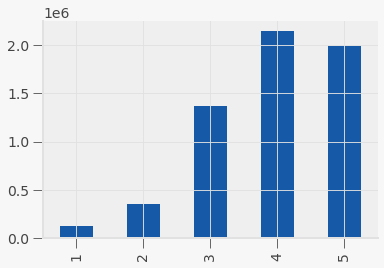

In [29]:
ratings["rating"].value_counts().sort_index().plot(kind="bar");

Let's also see how many users have rated `N` books, for all `N`
possible.

To do this, we will use `value_counts` twice (can you think of why?).

We will see a more flexible way of performing similar grouped operations in
a future lecture.

In [30]:
users_by_n = (
    ratings["user_id"]
    .value_counts()  # Series. Index: user_id, value: n ratings by user
    .value_counts()  # Series. Index: n_ratings by user, value: N_users with this many ratings
    .sort_index()    # Sort our Series by the index (number of ratings)
    .reset_index()   # Dataframe with columns `index` (from above) and `user_id`
    .rename(columns={"index": "N_ratings", "user_id": "N_users"})
)
users_by_n.head(10)

,N_ratings,N_users
0,19,1
1,20,1
2,21,3
3,22,13
4,23,5
5,24,11
6,25,13
7,26,23
8,27,34
9,28,26


Let's look at some statistics on that dataset.

In [31]:
users_by_n.describe()

,N_ratings,N_users
count,181.00000,181.000000
mean,109.01105,295.160221
std,52.41342,309.461848
min,19.00000,1.000000
25%,64.00000,40.000000
50%,109.00000,158.000000
75%,154.00000,538.000000
max,200.00000,964.000000


We can see the same data visually in a box plot.

N_ratings       AxesSubplot(0.125,0.125;0.352273x0.755)
N_users      AxesSubplot(0.547727,0.125;0.352273x0.755)
dtype: object

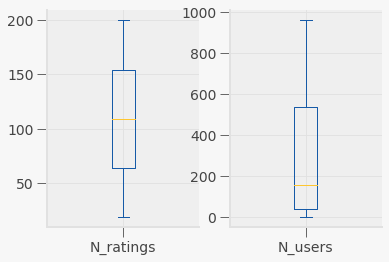

In [32]:
users_by_n.plot(kind="box", subplots=True)

Let's practice applying the want operator...

**Want**: Determine whether a relationship between the number of
ratings a user has written and the distribution of the ratings exists. (Maybe we
are an author hoping to inflate our ratings and wonder if we should
target "more experienced" Goodreads users, or focus on newcomers.)

Let's start from the result and work our way backwards:

1. We can answer our question if we have two similar DataFrames:
    - All ratings by the `N` (e.g. 5) users with the most ratings
    - All ratings by the `N` users with the least number of
      ratings
1. To get that, we will need to extract rows of `ratings` with
   `user_id` associated with the `N` most and least prolific raters
1. For that, we need the most and least active `user_id`s
1. To get that info, we need a count of how many ratings each user left.
    - We can get that with `df["user_id"].value_counts()`, so let's
      start there.

In [33]:
# step 4
n_ratings = ratings["user_id"].value_counts()
n_ratings.head()

12874    200
30944    200
52036    199
12381    199
28158    199
Name: user_id, dtype: int64

In [34]:
# step 3
N = 5
most_prolific_users = n_ratings.nlargest(5).index.tolist()
least_prolific_users = n_ratings.nsmallest(5).index.tolist()

In [35]:
# step 2
active_ratings = ratings.loc[ratings["user_id"].isin(most_prolific_users), :]
inactive_ratings = ratings.loc[ratings["user_id"].isin(least_prolific_users), :]

<AxesSubplot:title={'center':'Distribution of ratings by most active users'}>

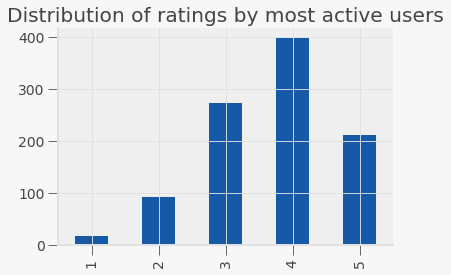

In [36]:
# step 1 -- get the answer!
active_ratings["rating"].value_counts().sort_index().plot(
    kind="bar", title="Distribution of ratings by most active users"
)

<AxesSubplot:title={'center':'Distribution of ratings by least active users'}>

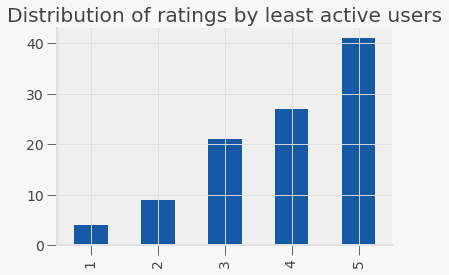

In [37]:
inactive_ratings["rating"].value_counts().sort_index().plot(
    kind="bar", title="Distribution of ratings by least active users"
)

Nice! From the picture above, the new users look much more
likely to leave 5 star ratings than more experienced users.

### Book Data

We know what you are probably thinking: "Isn't this a lecture on merging?
Why are we only using one dataset?"

We hear you.

Let's also load a dataset containing information on the actual books.

In [38]:
url = "https://datascience.quantecon.org/assets/data/goodreads_books.csv.zip"
books = pd.read_csv(url)
# we only need a few of the columns
books = books[["book_id", "authors", "title"]]
print("shape: ", books.shape)
print("dtypes:\n", books.dtypes, sep="")
books.head()

ValueError: Multiple files found in ZIP file. Only one file per ZIP: ['goodreads_books.csv.zip', 'cb_2016_us_county_5m.zip']

We could do similar interesting things with just the books dataset,
but we will skip it for now and merge them together.

In [ ]:
rated_books = pd.merge(ratings, books)

Now, let's see which books have been most often rated.

In [ ]:
most_rated_books_id = rated_books["book_id"].value_counts().nlargest(10).index
most_rated_books = rated_books.loc[rated_books["book_id"].isin(most_rated_books_id), :]
list(most_rated_books["title"].unique())

Let's use our `pivot_table` knowledge to compute the average rating
for each of these books.

In [ ]:
most_rated_books.pivot_table(values="rating", index="title")

These ratings seem surprisingly low, given that they are the most often
rated books on Goodreads.

I wonder what the bottom of the distribution looks like...

````{admonition} Exercise
:name: pd-mrg-dir4
See exercise 4 in the {ref}`exercise list <pd-mrg-ex>`.
````

Let's compute the average number of ratings for each book in our sample.

In [ ]:
average_ratings = (
    rated_books
    .pivot_table(values="rating", index="title")
    .sort_values(by="rating", ascending=False)
)
average_ratings.head(10)

What does the overall distribution of average ratings look like?

In [ ]:
# plot a kernel density estimate of average ratings
average_ratings.plot.density(xlim=(1, 5))

# or a histogram
average_ratings.plot.hist(bins=30, xlim=(1, 5))

It looks like most books have an average rating of just below 4.

## Extra Example: Airline Delays

Let's look at one more example.

This time, we will use a dataset from the [Bureau of Transportation
Statistics](https://www.transtats.bts.gov/OT_Delay/OT_DelayCause1.asp)
that describes the cause of all US domestic flight delays
in November 2016:

In [ ]:
url = "https://datascience.quantecon.org/assets/data/airline_performance_dec16.csv.zip"
air_perf = pd.read_csv(url)[["CRSDepTime", "Carrier", "CarrierDelay", "ArrDelay"]]
air_perf.info()
air_perf.head()

The `Carrier` column identifies the airline and the `CarrierDelay`
reports the number of minutes of the total delay assigned as the
"carrier's fault".

**Want**: Determine which airlines, on average, contribute most to
delays.

We can do this using `pivot_table`:

In [ ]:
avg_delays = (
    air_perf
    .pivot_table(index="Carrier", values="CarrierDelay", aggfunc="mean")
    .sort_values("CarrierDelay")
    .nlargest(10, "CarrierDelay")
)
avg_delays

The one issue with this dataset is that we don't know what all those two
letter carrier codes are!

Thankfully, we have a second dataset that maps the two letter code
into the full airline name.

In [ ]:
url = "https://datascience.quantecon.org/assets/data/airline_carrier_codes.csv.zip"
carrier_code = pd.read_csv(url)
carrier_code.tail()

Let's merge these names so we know which airlines we should avoid
flying...

In [ ]:
avg_delays_w_code = avg_delays.join(carrier_code)
avg_delays_w_code.sort_values("CarrierDelay", ascending=False)

Based on that information, which airlines would you avoid near
the holidays?

## Visualizing Merge Operations

As we did in the {doc}`reshape lecture <reshape>`, we will visualize the
various merge operations using artificial DataFrames.

First, we create some dummy DataFrames.

In [ ]:
dfL = pd.DataFrame(
    {"Key": ["A", "B", "A", "C"], "C1":[1, 2, 3, 4], "C2": [10, 20, 30, 40]},
    index=["L1", "L2", "L3", "L4"]
)[["Key", "C1", "C2"]]

print("This is dfL: ")
display(dfL)

dfR = pd.DataFrame(
    {"Key": ["A", "B", "C", "D"], "C3": [100, 200, 300, 400]},
    index=["R1", "R2", "R3", "R4"]
)[["Key", "C3"]]

print("This is dfR:")
display(dfR)

### `pd.concat`

Recall that calling `pd.concat(..., axis=0)` will stack DataFrames on top of
one another:

In [ ]:
pd.concat([dfL, dfR], axis=0)

Here's how we might visualize that.

```{figure} ../_static/concat_axis0.gif
:alt: concat\_axis0.gif
```

We can also set `axis=1` to stack side by side.

In [ ]:
pd.concat([dfL, dfR], axis=1)

Here's how we might visualize that.

```{figure} ../_static/concat_axis1.gif
:alt: concat\_axis1.gif
```

### `pd.merge`

The animation below shows a visualization of what happens when we call

In [ ]:
pd.merge(dfL, dfR, on="Key")

```{figure} ../_static/left_merge.gif
:alt: left\_merge.gif
```

Now, let's focus on what happens when we set `how="right"`.

Pay special attention to what happens when filling the output value for
the key `A`.

In [ ]:
pd.merge(dfL, dfR, on="Key", how="right")

```{figure} ../_static/right_merge.gif
:alt: right\_merge.gif
```

### Exercises With Artificial Data
````{admonition} Exercise
:name: pd-mrg-dir5
See exercise 5 in the {ref}`exercise list <pd-mrg-ex>`.
````
````{admonition} Exercise
:name: pd-mrg-dir6
See exercise 6 in the {ref}`exercise list <pd-mrg-ex>`.
````
````{admonition} Exercise
:name: pd-mrg-dir7
See exercise 7 in the {ref}`exercise list <pd-mrg-ex>`.
````

(pd-mrg-ex)=
## Exercises

### Exercise 1

Use your new `merge` skills to answer the final question from above: What
is the population density of each country? How much does it change over
time?

In [ ]:
# your code here

({ref}`back to text <pd-mrg-dir1>`)

### Exercise 2

Compare the `how="left"` with `how="inner"` options using the
DataFrames `wdi2017_no_US` and `sq_miles_no_germany`.

Are the different? How?

Will this happen for all pairs of DataFrames, or are `wdi2017_no_US` and
`sq_miles_no_germany` special in some way?

Also compare `how="right"` and `how="outer"` and answer the same
questions.

In [ ]:
# your code here

({ref}`back to text <pd-mrg-dir2>`)

### Exercise 3

Can you pick the correct argument for `how` such that `pd.merge(wdi2017, sq_miles,
how="left")` is equal to `pd.merge(sq_miles, wdi2017, how=XXX)`?

In [ ]:
# your code here

({ref}`back to text <pd-mrg-dir3>`)

### Exercise 4

Repeat the analysis above to determine the average rating for the books with the
*least* number ratings.

Is there a distinguishable difference in the average rating compared to
the most rated books?

Did you recognize any of the books?

In [ ]:
# your code here

({ref}`back to text <pd-mrg-dir4>`)

### Exercise 5

In writing, describe what the output looks like when you do
`pd.concat([dfL, dfR], axis=1)` (see above and/or run the cell below).

Be sure to describe things like:

- What are the columns? What about columns with the same name?
- What is the index?
- Do any `NaN`s get introduced? If so, where? Why?

In [ ]:
pd.concat([dfL, dfR], axis=1)

({ref}`back to text <pd-mrg-dir5>`)

### Exercise 6

Determine what happens when you run each of the two cells below.

For each cell, answer the list of questions from the previous exercise.

In [ ]:
# First code cell for above exercise
pd.concat([dfL, dfL], axis=0)

In [ ]:
# Second code cell for above exercise
pd.concat([dfR, dfR], axis=1)

({ref}`back to text <pd-mrg-dir6>`)

### Exercise 7

Describe in words why the output of `pd.merge(dfL, dfR,
how="right")` has more rows than either `dfL` or `dfR`.

Run the cell below to see the output of that operation.

In [ ]:
pd.merge(dfL, dfR, how="right")

({ref}`back to text <pd-mrg-dir7>`)